In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [3]:
root = 'Data'

total_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
torch.manual_seed(42)

print(total_data)

Dataset ImageFolder
    Number of datapoints: 13452
    Root location: Data/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [4]:
train_set, val_set , test_set= torch.utils.data.random_split(total_data, [11000,2000, 452])

train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
validation_loader = DataLoader(val_set, batch_size=10, shuffle=True)

class_names = total_data.classes

print(class_names)
print(f'Training images available: {len(train_set)}')
print(f'Validation images available:  {len(val_set)}')
print(f'Test images available: {len(test_set)}')

['100', '30', '50', '60', '70', '80', 'forward', 'left', 'right']
Training images available: 11000
Validation images available:  2000
Test images available: 452


Label: [5 3 2 2 6 4 0 0 1 3]
Class: 80 60 50 50 forward 70 100 100 30 60


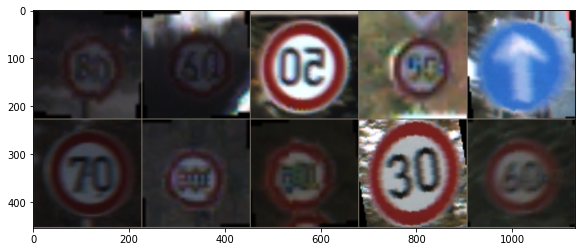

In [5]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [6]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [7]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [9]:
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
     840
      10
________
 5610902


In [10]:
import time
start_time = time.time()

epochs = 10

max_trn_batch = len(train_set)/10
max_tst_batch = len(val_set)/10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%100 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{len(train_set)}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss.item())
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(validation_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test).item()
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  100 [  1000/11000]  loss: 1.62634528  accuracy:  28.900%
epoch:  0  batch:  200 [  2000/11000]  loss: 2.04780626  accuracy:  32.750%
epoch:  0  batch:  300 [  3000/11000]  loss: 1.07217526  accuracy:  35.233%
epoch:  0  batch:  400 [  4000/11000]  loss: 1.59075987  accuracy:  37.325%
epoch:  0  batch:  500 [  5000/11000]  loss: 1.19894183  accuracy:  39.300%
epoch:  0  batch:  600 [  6000/11000]  loss: 1.23282933  accuracy:  40.617%
epoch:  0  batch:  700 [  7000/11000]  loss: 1.88640749  accuracy:  42.014%
epoch:  0  batch:  800 [  8000/11000]  loss: 0.73595035  accuracy:  43.350%
epoch:  0  batch:  900 [  9000/11000]  loss: 0.80644083  accuracy:  44.700%
epoch:  0  batch: 1000 [ 10000/11000]  loss: 0.85887814  accuracy:  46.420%
epoch:  0  batch: 1100 [ 11000/11000]  loss: 0.71201551  accuracy:  48.218%
epoch:  1  batch:  100 [  1000/11000]  loss: 0.98823035  accuracy:  66.200%
epoch:  1  batch:  200 [  2000/11000]  loss: 0.91964161  accuracy:  68.400%
epoch:  1  b

epoch:  9  batch: 1000 [ 10000/11000]  loss: 0.16133782  accuracy:  95.940%
epoch:  9  batch: 1100 [ 11000/11000]  loss: 0.13955860  accuracy:  95.936%

Duration: 2149 seconds


In [11]:
torch.save(CNNmodel.state_dict(), 'CustomImageCNNModel.pt')

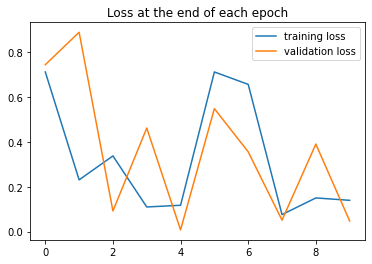

In [12]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

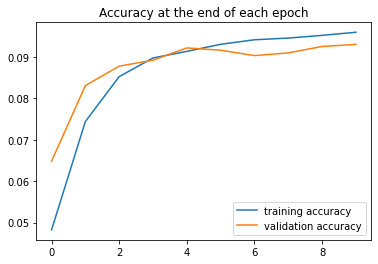

In [73]:
plt.plot([t/len(train_set)/10 for t in train_correct], label='training accuracy')
plt.plot([t/len(val_set)/10 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [77]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/2000:.3f}%')

[tensor(1296), tensor(1661), tensor(1755), tensor(1784), tensor(1843), tensor(1832), tensor(1806), tensor(1819), tensor(1850), tensor(1860)]
Test accuracy: 93.000%


In [78]:
a=0
false=[]
for x in range(len(test_set)):
    
    CNNmodel.eval()
    with torch.no_grad():
        new_pred = CNNmodel(test_set[x][0].view(1,3,224,224)).argmax()
        a += (new_pred != test_set[x][1]).sum()
        print(x,f'Predicted value: {new_pred.item()} {test_set[x][1]} {class_names[new_pred.item()]}')
        if new_pred.item() != test_set[x][1]:
            false.append(x)
        

0 Predicted value: 2 2 50
1 Predicted value: 3 3 60
2 Predicted value: 4 4 70
3 Predicted value: 2 2 50
4 Predicted value: 0 0 100
5 Predicted value: 1 1 30
6 Predicted value: 1 1 30
7 Predicted value: 1 1 30
8 Predicted value: 3 3 60
9 Predicted value: 2 2 50
10 Predicted value: 0 0 100
11 Predicted value: 6 6 forward
12 Predicted value: 2 2 50
13 Predicted value: 6 6 forward
14 Predicted value: 8 8 right
15 Predicted value: 2 2 50
16 Predicted value: 5 5 80
17 Predicted value: 4 3 70
18 Predicted value: 7 7 left
19 Predicted value: 4 4 70
20 Predicted value: 1 1 30
21 Predicted value: 1 1 30
22 Predicted value: 2 2 50
23 Predicted value: 7 7 left
24 Predicted value: 2 2 50
25 Predicted value: 2 2 50
26 Predicted value: 7 6 left
27 Predicted value: 7 7 left
28 Predicted value: 5 5 80
29 Predicted value: 3 3 60
30 Predicted value: 6 6 forward
31 Predicted value: 1 1 30
32 Predicted value: 2 2 50
33 Predicted value: 4 4 70
34 Predicted value: 2 2 50
35 Predicted value: 4 4 70
36 Predict

307 Predicted value: 6 6 forward
308 Predicted value: 0 0 100
309 Predicted value: 5 5 80
310 Predicted value: 7 7 left
311 Predicted value: 2 2 50
312 Predicted value: 1 1 30
313 Predicted value: 8 8 right
314 Predicted value: 4 4 70
315 Predicted value: 0 0 100
316 Predicted value: 0 0 100
317 Predicted value: 6 6 forward
318 Predicted value: 2 2 50
319 Predicted value: 5 5 80
320 Predicted value: 1 1 30
321 Predicted value: 2 2 50
322 Predicted value: 4 1 70
323 Predicted value: 4 4 70
324 Predicted value: 5 5 80
325 Predicted value: 5 5 80
326 Predicted value: 1 1 30
327 Predicted value: 4 4 70
328 Predicted value: 6 6 forward
329 Predicted value: 2 1 50
330 Predicted value: 8 8 right
331 Predicted value: 1 1 30
332 Predicted value: 3 3 60
333 Predicted value: 6 6 forward
334 Predicted value: 7 7 left
335 Predicted value: 5 5 80
336 Predicted value: 2 2 50
337 Predicted value: 1 2 30
338 Predicted value: 1 1 30
339 Predicted value: 0 1 100
340 Predicted value: 0 0 100
341 Predicted

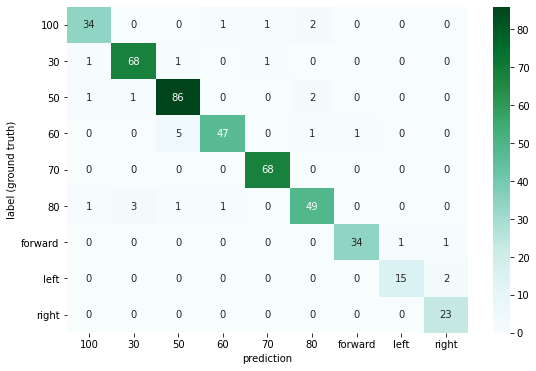

Test accuracy: 424/452 =  93.805%


In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sn  # for heatmaps

# Create a loader for the entire the test set
test_load_all = DataLoader(test_set, batch_size=len(test_set), shuffle=False)
false=[]
x=0
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = CNNmodel(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();
print(f'Test accuracy: {correct.item()}/{len(test_set)} = {correct.item()*100/(len(test_set)):7.3f}%')

In [80]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

28

In [81]:
print(misses)

[ 17  26  68  80  95 106 111 121 126 175 193 197 233 242 245 264 283 284
 296 308 322 339 353 381 388 389 394 441]


Predicted value: 5 5


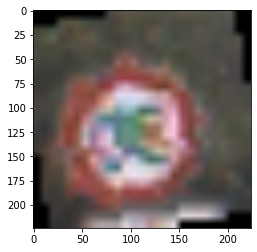

In [88]:
x = 95


im = inv_normalize(test_set[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
test_set[x][0].shape

CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(test_set[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {test_set[x][1]}')